# Top wall feature tests

This notebook is investigating the features of the top wall, and why there is the long tail in top wall SP distributions

This notebook is now looking at

In [36]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
import glob
import pickle as pkl

In [37]:
CRT_Wall_Dict = {
       "South": 1,
       "North": 2,
       "West": 3,
       "East": 4,
       "Bottom": 0,
       "Top Low": 5,
       "Top High": 6
       }

CRT_Wall_Arr = ["Bottom", "South", "North", "West", "East", "Top Low", "Top High"]

In [38]:
def list_matching_files(folder_path, pattern):
    search_pattern = os.path.join(folder_path, pattern)
    files = glob.glob(search_pattern)
    return [f for f in files if os.path.isfile(f)]

# path = "/exp/sbnd/data/users/jbateman/workdir/crt/run/"
path ="/pnfs/sbnd/persistent/users/jbateman/crt/run/"
run="017985" # [017985, 017987, 018019]
# run="017985"
folder_path = path+run

# matching_files = list_matching_files(folder_path, "crtana_data_*")
matching_files = list_matching_files(folder_path, "crt_ana_*")

# Check how many files there are - memory gets upset if you try load too many
# Splitting the files into batches of 3 for now
batch_number = 0
batch_size = 75
# Theres probably a better way to loop this, but this is good enough for now!
print("Total batches = ", int(np.ceil(len(matching_files)/batch_size)))
matching_files = matching_files[batch_number*batch_size:(batch_number+1)*batch_size]

save = False # Decide whether to save the data to a pkl for later. If unsure, leave False

Total batches =  3


In [39]:
track_features = ["tr_start_x", "tr_start_y", "tr_start_z", "tr_end_x", "tr_end_y", "tr_end_z", "tr_dir_x", "tr_dir_y", "tr_dir_z", "tr_ts0", "tr_ts1", "tr_pe", "tr_length", "tr_tof", "tr_theta", "tr_phi", "tr_triple", "tr_tagger1", "tr_tagger2", "tr_tagger3", "tr_channel_set", "tr_adc_set",'tdc_channel','tdc_timestamp','tdc_offset','tdc_name']


# Load the first file to get the columns
ttree = uproot.open(matching_files[0])
print("Loading ", matching_files[0], "...")

recodata = ttree['crtana/tree'].arrays(track_features, library='ak')
# recodata = ttree['crtana/tree'].arrays(library='ak')

# Merge all the files into one dataframe (now an awkward array, which speeds everything up so much)
for file in matching_files[1:]:
    print("Loading ", file, "...")
    ttree = uproot.open(file)

    temp_recodata = ttree['crtana/tree'].arrays(track_features, library='ak')
    # temp_recodata = ttree['crtana/tree'].arrays(library='ak')

    recodata = ak.concatenate([recodata, temp_recodata])
    ttree.close()

Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_aa.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ab.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ac.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ad.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ae.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_af.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ag.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ah.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ai.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_aj.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ak.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_al.root ...
Loading  /pnfs/sbnd/persiste

In [40]:
trk_start_x = recodata.tr_start_x
trk_start_y = recodata.tr_start_y
trk_start_z = recodata.tr_start_z

trk_end_x = recodata.tr_end_x
trk_end_y = recodata.tr_end_y
trk_end_z = recodata.tr_end_z

trk_ts0 = recodata.tr_ts0
trk_ts1 = recodata.tr_ts1

trk_wall_1 = recodata.tr_tagger1
trk_wall_2 = recodata.tr_tagger2
trk_wall_3 = recodata.tr_tagger3

tdc_names = recodata.tdc_name
tdc_time = recodata.tdc_timestamp

# Find the indices of 'crtt1', 'rwm', and 'etrig' in tdc_names
crtt1_indices = ak.argmax(tdc_names == b'crtt1', axis=1)
rwm_indices = ak.argmax(tdc_names == b'rwm', axis=1)
etrig_indices = ak.argmax(tdc_names == b'etrig', axis=1)


# # Filter out events with missing TDC data
valid_events = (crtt1_indices != -1) & (rwm_indices != -1) & (etrig_indices != -1)
# Apply the mask to filter valid events
tdc_names = tdc_names[valid_events]
tdc_time = tdc_time[valid_events]

# Get only valid events
trk_start_x = trk_start_x[valid_events]
trk_start_y = trk_start_y[valid_events]
trk_start_z = trk_start_z[valid_events]

trk_end_x = trk_end_x[valid_events]
trk_end_y = trk_end_y[valid_events]
trk_end_z = trk_end_z[valid_events]

trk_wall_1 = trk_wall_1[valid_events]
trk_wall_2 = trk_wall_2[valid_events]
trk_wall_3 = trk_wall_3[valid_events]

trk_ts0 = trk_ts0[valid_events]
trk_ts1 = trk_ts1[valid_events]

# Extract the TDC values
tdc_crt = tdc_time[tdc_names == b'crtt1']
tdc_rwm = tdc_time[tdc_names == b'rwm']
tdc_etrig = tdc_time[tdc_names == b'etrig']

In [41]:

trk_start_x = recodata.tr_start_x
trk_start_y = recodata.tr_start_y
trk_start_z = recodata.tr_start_z
print("Starting with {} tracks".format(len(ak.flatten(trk_start_x))))
trk_end_x = recodata.tr_end_x
trk_end_y = recodata.tr_end_y
trk_end_z = recodata.tr_end_z

trk_ts0 = recodata.tr_ts0
trk_ts1 = recodata.tr_ts1

trk_wall_1 = recodata.tr_tagger1
trk_wall_2 = recodata.tr_tagger2
trk_wall_3 = recodata.tr_tagger3

tdc_names = recodata.tdc_name
tdc_time = recodata.tdc_timestamp

# Find the indices of 'crtt1', 'rwm', and 'etrig' in tdc_names
crtt1_indices = ak.argmax(tdc_names == b'crtt1', axis=1)
rwm_indices = ak.argmax(tdc_names == b'rwm', axis=1)
etrig_indices = ak.argmax(tdc_names == b'etrig', axis=1)

# # Filter out events with missing TDC data
valid_events = (crtt1_indices != -1) & (rwm_indices != -1) & (etrig_indices != -1)
# Apply the mask to filter valid events
tdc_names = tdc_names[valid_events]
tdc_time = tdc_time[valid_events]

# Get only valid events
trk_start_x = trk_start_x[valid_events]
trk_start_y = trk_start_y[valid_events]
trk_start_z = trk_start_z[valid_events]

trk_end_x = trk_end_x[valid_events]
trk_end_y = trk_end_y[valid_events]
trk_end_z = trk_end_z[valid_events]

trk_wall_1 = trk_wall_1[valid_events]
trk_wall_2 = trk_wall_2[valid_events]
trk_wall_3 = trk_wall_3[valid_events]

trk_ts0 = trk_ts0[valid_events]
trk_ts1 = trk_ts1[valid_events]

# Extract the TDC values
tdc_crt = tdc_time[tdc_names == b'crtt1']
tdc_rwm = tdc_time[tdc_names == b'rwm']
tdc_etrig = tdc_time[tdc_names == b'etrig']

# Check that none of the entries in each array have length zero
filter = []
for crt, rwm, etrig in zip(tdc_crt, tdc_rwm, tdc_etrig):
    try:
        if len(crt) == 0 or len(rwm) == 0 or len(etrig) == 0:
            filter.extend([False])
        else:
            filter.extend([True])
    except:
        filter.extend([False])

# Apply the filter to the arrays
tdc_etrig_flat = ak.flatten(tdc_etrig[filter]) % 1e12
tdc_rwm_flat = ak.flatten(tdc_rwm[filter]) % 1e12

# Calculate delta_t
delta_t = tdc_etrig_flat - tdc_rwm_flat
# Calculate relative timestamps

trk_ts0 = trk_ts0[filter]
trk_ts1 = trk_ts1[filter]

relative_ts0_vec = trk_ts0 + delta_t
relative_ts1_vec = trk_ts1 + delta_t

# Filter the tracks
trk_start_x = trk_start_x[filter]
trk_start_y = trk_start_y[filter]
trk_start_z = trk_start_z[filter]
print("Filtering for complete TDC entries only:  {} tracks".format(len(ak.flatten(trk_start_x))))


trk_end_x = trk_end_x[filter]
trk_end_y = trk_end_y[filter]
trk_end_z = trk_end_z[filter]

trk_wall_1 = trk_wall_1[filter]
trk_wall_2 = trk_wall_2[filter]
trk_wall_3 = trk_wall_3[filter]

# Flatten arrays and convert to numpy
trk_start_x = np.array(ak.flatten(trk_start_x))
trk_start_y = np.array(ak.flatten(trk_start_y))
trk_start_z = np.array(ak.flatten(trk_start_z))

trk_end_x = np.array(ak.flatten(trk_end_x))
trk_end_y = np.array(ak.flatten(trk_end_y))
trk_end_z = np.array(ak.flatten(trk_end_z))

trk_wall_1 = np.array(ak.flatten(trk_wall_1))
trk_wall_2 = np.array(ak.flatten(trk_wall_2))
trk_wall_3 = np.array(ak.flatten(trk_wall_3))

trk_ts0 = np.array(ak.flatten(relative_ts0_vec)) / 1e3  # convert from ns to μs
trk_ts1 = np.array(ak.flatten(relative_ts1_vec)) / 1e3  # convert from ns to μs

Starting with 30114768 tracks
Filtering for complete TDC entries only:  28742585 tracks


Now we do a quick sanity check:


Do we see the top hat with tracks?

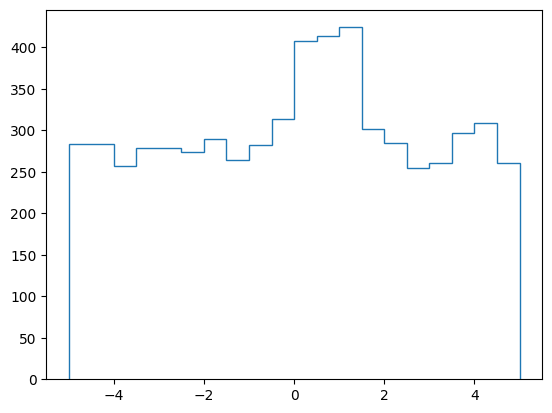

In [42]:
plt.hist(trk_ts0 + 1, range=(-5, 5), bins=20, histtype='step', label='ts0')
plt.show()

In [60]:
# Now select the beam window
window_range = (0,5)
in_window_filter = ((trk_ts0 +  1 > window_range[0]) & (trk_ts0 + 1 < window_range[1]))

trk_ts0_in_window = trk_ts0[in_window_filter]

trk_start_in_x = trk_start_x[in_window_filter]
trk_start_in_y = trk_start_y[in_window_filter]
trk_start_in_z = trk_start_z[in_window_filter]

trk_end_in_x = trk_end_x[in_window_filter]
trk_end_in_y = trk_end_y[in_window_filter]
trk_end_in_z = trk_end_z[in_window_filter]

trk_wall_1_in = trk_wall_1[in_window_filter]
trk_wall_2_in = trk_wall_2[in_window_filter]
trk_wall_3_in = trk_wall_3[in_window_filter]

print("Filtering for the beam window:  {} tracks".format(len(trk_start_in_x)))


Filtering for the beam window:  3213 tracks


In [61]:
timing_range = 500 
out_window_filter = (((trk_ts0 + 1 < window_range[0]) & (trk_ts0 + 1 > -timing_range)) | ((trk_ts0 + 1 > window_range[1]) & (trk_ts0 + 1 < timing_range)))


time_norm = 2*timing_range - (window_range[1] - window_range[0])
trk_ts0_out_window = trk_ts0[out_window_filter]

trk_start_out_x = trk_start_x[out_window_filter]
trk_start_out_y = trk_start_y[out_window_filter]
trk_start_out_z = trk_start_z[out_window_filter]

trk_end_out_x = trk_end_x[out_window_filter]
trk_end_out_y = trk_end_y[out_window_filter]
trk_end_out_z = trk_end_z[out_window_filter]

trk_wall_1_out = trk_wall_1[out_window_filter]
trk_wall_2_out = trk_wall_2[out_window_filter]
trk_wall_3_out = trk_wall_3[out_window_filter]

Text(0.5, 0, 'CRT Track time [μs]')

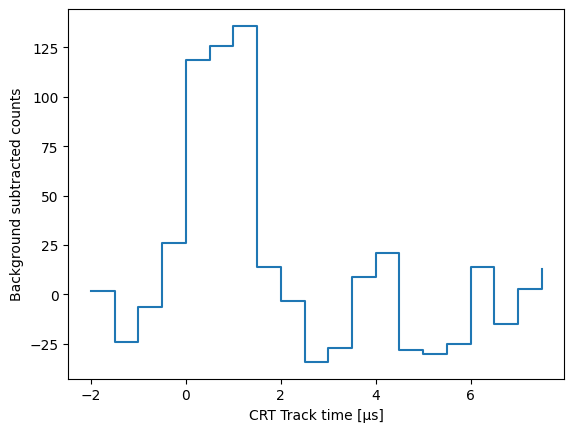

In [69]:
# Do a quick background substraction

bins = 20
range_time = (-2,8)
binwidth = (range_time[1] - range_time[0]) / bins

background = len(trk_ts0_out_window) / time_norm * binwidth

hist, bins = np.histogram(trk_ts0 + 1, bins=bins, range=range_time)

hist = hist - background
plt.step(bins[:-1], hist, where='post')
plt.ylabel('Background subtracted counts')
plt.xlabel('CRT Track time [μs]')
# plt.title('Track that hits Top low & Top high')

Text(0.5, 1.0, 'Track that hits Top low & Top high')

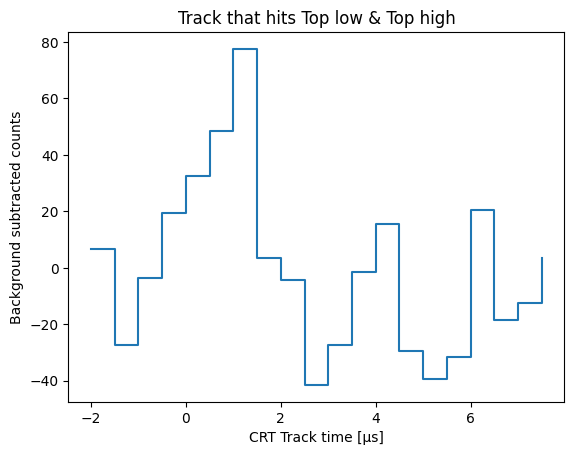

In [83]:
def top_wall_filter(tagger_arr):
    return np.logical_and(np.any(tagger_arr == 5, axis=1), np.any(tagger_arr == 6, axis=1))

def not_top_wall_filter(tagger_arr):
    return np.logical_not(top_wall_filter(tagger_arr))

tagger_arr = np.transpose([trk_wall_1_in, trk_wall_2_in, trk_wall_3_in])
top_wall_in_filter = top_wall_filter(tagger_arr)

trk_start_in_top_x = trk_start_in_x[top_wall_in_filter]
trk_start_in_top_y = trk_start_in_y[top_wall_in_filter]
trk_start_in_top_z = trk_start_in_z[top_wall_in_filter]

trk_end_in_top_x = trk_end_in_x[top_wall_in_filter]
trk_end_in_top_y = trk_end_in_y[top_wall_in_filter]
trk_end_in_top_z = trk_end_in_z[top_wall_in_filter]

tagger_arr = np.transpose([trk_wall_1_out, trk_wall_2_out, trk_wall_3_out])
top_wall_out_filter = top_wall_filter(tagger_arr)

trk_start_out_top_x = trk_start_out_x[top_wall_out_filter]
trk_start_out_top_y = trk_start_out_y[top_wall_out_filter]
trk_start_out_top_z = trk_start_out_z[top_wall_out_filter]

trk_end_out_top_x = trk_end_out_x[top_wall_out_filter]
trk_end_out_top_y = trk_end_out_y[top_wall_out_filter]
trk_end_out_top_z = trk_end_out_z[top_wall_out_filter]

tagger_arr = np.transpose([trk_wall_1, trk_wall_2, trk_wall_3])
top_wall_filter = top_wall_filter(tagger_arr)
trk_ts0_top = trk_ts0[top_wall_filter]

not_top_filter = np.logical_not(top_wall_filter)
trk_ts0_not_top = trk_ts0[not_top_filter]

# plt.hist(trk_ts0_top + 1, range=(-5, 5), bins=20, histtype='step', label='ts0')

# Do background subtraction for the top wall
range_time = (-2,8)
bins = 20
binwidth = (range_time[1] - range_time[0]) / bins

background_filter = ((trk_ts0_top + 1 < window_range[0]) & (trk_ts0_top + 1 > -timing_range))
time_norm = timing_range + window_range[0]
background_top = len(trk_ts0_top[background_filter]) / time_norm * binwidth

hist, bins = np.histogram(trk_ts0_top + 1, bins=bins, range=range_time)
hist = hist - background_top
plt.step(bins[:-1], hist, where='post')
plt.ylabel('Background subtracted counts')
plt.xlabel('CRT Track time [μs]')
plt.title('Track that hits Top low & Top high')


Text(0.5, 1.0, 'Track that hits Top low & Top high')

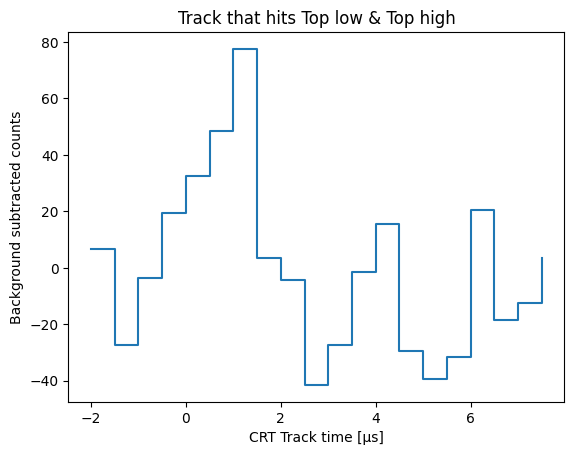

In [76]:
# plt.hist(trk_ts0_top + 1, range=(-5, 5), bins=20, histtype='step', label='ts0')

# Do background subtraction for the top wall
range_time = (-2,8)
bins = 20
binwidth = (range_time[1] - range_time[0]) / bins

background_filter = ((trk_ts0_top + 1 < window_range[0]) & (trk_ts0_top + 1 > -timing_range))
time_norm = timing_range + window_range[0]
background_top = len(trk_ts0_top[background_filter]) / time_norm * binwidth

hist, bins = np.histogram(trk_ts0_top + 1, bins=bins, range=range_time)
hist = hist - background_top
plt.step(bins[:-1], hist, where='post')
plt.ylabel('Background subtracted counts')
plt.xlabel('CRT Track time [μs]')
plt.title('Track that hits Top low & Top high')

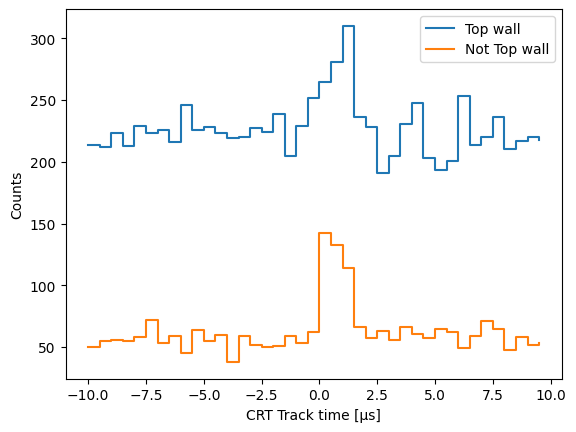

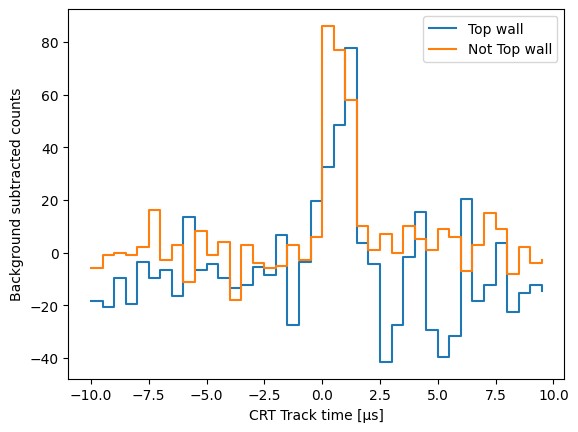

In [103]:
# plt.hist(trk_ts0_top + 1, range=(-5, 5), bins=20, histtype='step', label='ts0')

# Do background subtraction for the top wall
range_time = (-10,10)
timing_range = 500
n_bins = 40
binwidth = (range_time[1] - range_time[0]) / n_bins
time_norm = timing_range + window_range[0]

hist, bins = np.histogram(trk_ts0_top + 1, bins=n_bins, range=range_time)
# hist = hist - background_top
plt.step(bins[:-1], hist, where='post', label='Top wall')
# plt.ylabel('Background subtracted counts')
# plt.xlabel('CRT Track time [μs]')
# plt.title('Track that hits Top low & Top high')
# Do background subtraction for not the top wall

hist, bins = np.histogram(trk_ts0_not_top + 1, bins=n_bins, range=range_time)
plt.step(bins[:-1], hist, where='post', label='Not Top wall')
plt.ylabel('Counts')
plt.xlabel('CRT Track time [μs]')
plt.legend()
plt.show()

# plt.hist(trk_ts0_top + 1, range=(-5, 5), bins=20, histtype='step', label='ts0')

# Do background subtraction for the top wall
background_filter = ((trk_ts0_top + 1 < window_range[0]) & (trk_ts0_top + 1 > -timing_range))
background_top = len(trk_ts0_top[background_filter]) / time_norm * binwidth

hist, bins = np.histogram(trk_ts0_top + 1, bins=n_bins, range=range_time)
hist = hist - background_top
plt.step(bins[:-1], hist, where='post', label='Top wall')
# plt.ylabel('Background subtracted counts')
# plt.xlabel('CRT Track time [μs]')
# plt.title('Track that hits Top low & Top high')
# Do background subtraction for not the top wall

background_filter = ((trk_ts0_not_top + 1 < window_range[0]) & (trk_ts0_not_top + 1 > -timing_range))
time_norm = timing_range + window_range[0]
background_not_top = len(trk_ts0_not_top[background_filter]) / time_norm * binwidth

hist, bins = np.histogram(trk_ts0_not_top + 1, bins=bins, range=range_time)
hist = hist - background_not_top
plt.step(bins[:-1], hist, where='post', label='Not Top wall')
plt.ylabel('Background subtracted counts')
plt.xlabel('CRT Track time [μs]')
plt.legend()
# plt.title('Track that DO NOT hit Top low & Top high')
# plt.title('Track that DO NOT hit Top low & Top high')

### Interlude: what do our in-window top tracks look like?

In [47]:
track_vector_x = np.transpose([trk_start_in_top_x, trk_end_in_top_x])
track_vector_y = np.transpose([trk_start_in_top_y, trk_end_in_top_y])
track_vector_z = np.transpose([trk_start_in_top_z, trk_end_in_top_z])

In [48]:
# fig = go.Figure()
# fig.update_layout(title='Top Wall Tracks', scene=dict(
#     xaxis_title='X',
#     yaxis_title='Z',
#     zaxis_title='Y'
# ))

# for i in range(290):
#     fig.add_trace(go.Scatter3d(
#         x=track_vector_x[i],
#         y=track_vector_z[i],
#         z=track_vector_y[i],
#         mode='lines',
#         line=dict(width=2)
#     ))

# fig.show()

## Having a look at angle distributions

In [49]:
bnb_vector = np.array([0, 0, 1])
track_vector_in = np.transpose([trk_end_in_top_x - trk_start_in_top_x, trk_end_in_top_y - trk_start_in_top_y, trk_end_in_top_z - trk_start_in_top_z])
track_vector_out = np.transpose([trk_end_out_top_x - trk_start_out_top_x, trk_end_out_top_y - trk_start_out_top_y, trk_end_out_top_z - trk_start_out_top_z])

In [50]:
def vec_angle(vector, ref_vector=[0,0,1]):
    # bnb_vec = [0,0,1]

    dot_product = np.dot(vector, ref_vector)
    mag_bnb = np.linalg.norm(ref_vector)
    mag_vec = np.linalg.norm(vector, axis=1)

    cos_theta = dot_product/(mag_bnb*mag_vec)
    return cos_theta

def gauss(x, H, A, x0, sigma): 
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))


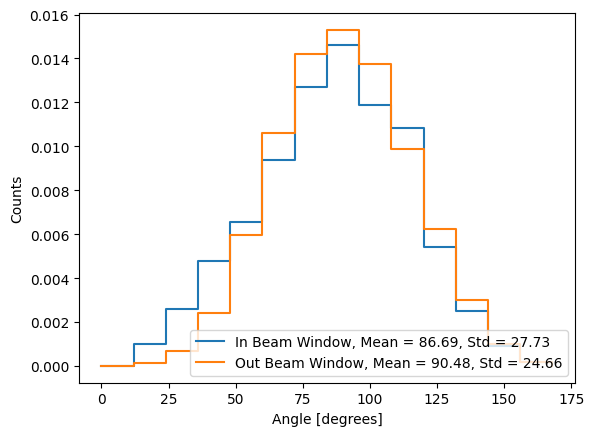

In [52]:
bins = 15
range_angle = (0, 180)

vec_angles_in = np.rad2deg(np.arccos((vec_angle(track_vector_in, bnb_vector))))
mean_in, std_in = np.mean(vec_angles_in), np.std(vec_angles_in)
hist_angles_in, bins = np.histogram(vec_angles_in, bins=bins, range=range_angle, density=True)

vec_angles_out = np.rad2deg(np.arccos((vec_angle(track_vector_out, bnb_vector))))
mean_out, std_out = np.mean(vec_angles_out), np.std(vec_angles_out)
hist_angles_out, bins = np.histogram(vec_angles_out, bins=bins, range=range_angle, density=True)

plt.step(bins[:-1], hist_angles_in, where='post', label='In Beam Window, Mean = {:.2f}, Std = {:.2f}'.format(mean_in, std_in))
plt.step(bins[:-1], hist_angles_out, where='post', label='Out Beam Window, Mean = {:.2f}, Std = {:.2f}'.format(mean_out, std_out))
plt.ylabel('Counts')
plt.xlabel('Angle [degrees]')
plt.legend(loc='lower right')
plt.show()